In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation

2024-01-14 22:04:15.242180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 22:04:15.242244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 22:04:15.243231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 22:04:15.249494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 22:04:16.232090: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:15]}

In [6]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

label_features=['EW', 'EW_Type', 'EW_Node', 'EW_Node_Location', 'NS', 'NS_Type', 'NS_Node', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced,
                                      with_labels=True,
                                      train_val_split=0.7, input_stride=1, padding='none',
                                      pad_location_labels=1,
                                      input_history_steps=1, input_future_steps=100, seed=69)


=========================Creating Generator=======================
Seed: 69
nTrain: 175 nVal: 75 (0.70)
Padding: none
Scaling: True 
Horizons: 1-100 @ stride 1
Sin-Transformed features: ['True Anomaly (deg)', 'Argument of Periapsis (deg)']
Padding node locations (1)
=========================Finished Generator=======================


In [7]:
train_combined, val_combined = ds_gen.get_datasets(batch_size=256, label_features=['EW_Type', 'NS_Type'], with_identifier=False, only_nodes=True, shuffle=True, stride=1)

print(train_combined.element_spec)


2024-01-14 22:05:11.966214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 22:05:11.988198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 22:05:11.988273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 22:05:11.990219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-14 22:05:11.990310: I external/local_xla/xla/stream_executor

(TensorSpec(shape=(None, 101, 9), dtype=tf.float64, name=None), {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 101, 9)]             0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 909)                  0         ['Input[0][0]']               
                                                                                                  
 dense_8 (Dense)             (None, 128)                  116480    ['flatten_2[0][0]']           
                                                                                                  
 dropout_8 (Dropout)         (None, 128)                  0         ['dense_8[0][0]']             
                                                                                            

/home/david/Code/splid-challenge/base/prediction_models.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


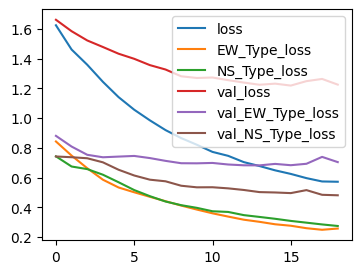

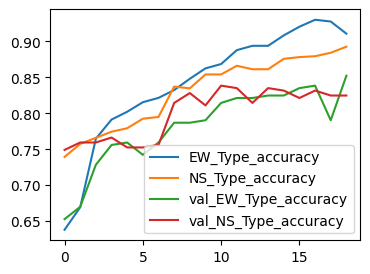

In [11]:
# train_combined, val_combined = ds_gen.get_datasets(batch_size=512, label_features=['EW_Type', 'NS_Type'], with_identifier=False, shuffle=True, stride=4)
# print(train_combined.element_spec)

#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[128,64,32], l2_reg=0.0001, mixed_dropout=0.5, lr_scheduler=[70000,0.9], seed=0)
#dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.15, lstm_layers=[64,64], dense_layers=[32,16], l2_reg=0.0, lr_scheduler=[25000,0.9], seed=1)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[1], l2_reg=0.00001, mixed_dropout=0.2, lr_scheduler=[70000,0.9], seed=0)

dense_model.summary()

# temporary fix to allow class weights
# train_combined = train_combined.map(lambda x,y:(x,y[f'EW_Node']))
# val_combined = val_combined.map(lambda x,y:(x,y[f'EW_Node'])) 

w_0 = 21.3
w_1 = 22.0
w_2 = 16.0
w_3 = 2.9

hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=20, verbose=2, plot_hist=False,
                       #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                       callbacks=[])
#dense_model.model.save('models/ew_ns_classifier_new.hdf5')

dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [8]:
dense_model.model.save('submission/models/ew_ns_type_classifier.hdf5')

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Starting training. Optimizing "val_accuracy"
Epoch 1/10
3/3 - 0s - loss: 0.4452 - accuracy: 0.8162 - val_loss: 0.6427 - val_accuracy: 0.7634 - 49ms/epoch - 16ms/step
Epoch 2/10
3/3 - 0s - loss: 0.4228 - accuracy: 0.8108 - val_loss: 0.6000 - val_accuracy: 0.8065 - 44ms/epoch - 15ms/step
Epoch 3/10
3/3 - 0s - loss: 0.3817 - accuracy: 0.8450 - val_loss: 0.5734 - val_accuracy: 0.8280 - 56ms/epoch - 19ms/step
Epoch 4/10
3/3 - 0s - loss: 0.3517 - accuracy: 0.8577 - val_loss: 0.5642 - val_accuracy: 0.8172 - 47ms/epoch - 16ms/step
Epoch 5/10
3/3 - 0s - loss: 0.3401 - accuracy: 0.8883 - val_loss: 0.5424 - val_accuracy: 0.8387 - 46ms/epoch - 15ms/step
Epoch 6/10
3/3 - 0s - loss: 0.3214 - accuracy: 0.8919 - val_loss: 0.5416 - val_accuracy: 0.8710 - 47ms/epoch - 16ms/step
Epoch 7/10
3/3 - 0s - loss: 0.2878 - accuracy: 0.9027 - val_loss: 0.5728 - val_accuracy: 0.8065 - 43ms/epoch - 14ms/step
Epoch 8/10
3/3 - 0s - loss: 0.2878 - accuracy: 0.9009 - val_loss: 0.5489 - val_accuracy: 0.8710 - 42ms/epoch

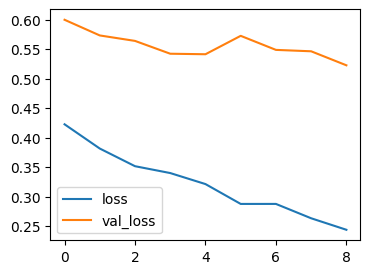

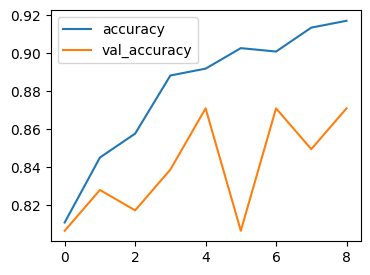

In [6]:
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=10, verbose=2, plot_hist=False, callbacks=[])
dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [6]:
#dense_model.model.save('models/ew_ns_classifier.hdf5')

In [6]:
dense_model = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240114_161406-6yf4r4do/files\model_6yf4r4do.hdf5')


In [12]:
eval_df, gt_df, evaluator = evaluation.evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                 dense_model,
                                                 model_outputs=['EW_Type', 'NS_Type'],
                                                 train=False,
                                                 majority_segment_labels=False,
                                                 with_initial_node=True
                                                 only_initial_nodes=True)
                                                 
# Dense: worse
# LSTM 40-40@2 same-padding: 0.51
# LSTM 40-40@2 zero-padding: 0.49
# LSTM 80-80@5: 0.49

# TODO: determine class imbalance for the classifier - maybe nodes should be trained without considering SS at all, as it will never be a necessary classification?
# Maybe also really only train on changepoints...
# TODO: for type, maybe take majority value between timesteps?
# -> New approach seems to be much better for initial nodes!

10/10 - 0s - 88ms/epoch - 9ms/step
Assuming perfect nodes
Precision: 0.73
TP: 172 FP: 65


In [7]:
eval_df, gt_df, evaluator = evaluate_classifier(ds_gen, challenge_data_dir / 'train_labels.csv',
                                                 dense_model.model,
                                                 model_outputs=['EW_Type', 'NS_Type'],
                                                 train=True,
                                                 with_initial_node=True)

15707/15707 - 39s - 39s/epoch - 2ms/step
Assuming perfect nodes
Precision: 0.95
TP: 449 FP: 25


In [13]:
eval_df = eval_df.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
eval_df

,ObjectID,TimeIndex,EW_Node_Pred,EW_Node,Direction,Type,Node
0,104,99,0.0,AD,EW,NK,AD
1,104,126,0.0,AD,EW,NK,AD
2,107,68,2.0,IK,EW,CK,IK
3,107,74,0.0,AD,EW,NK,AD
4,114,200,2.0,IK,EW,CK,IK
...,...,...,...,...,...,...,...
57,215,912,0.0,AD,EW,NK,AD
58,215,930,2.0,IK,EW,HK,IK
59,221,275,0.0,AD,EW,NK,AD
60,221,298,0.0,AD,EW,NK,AD


In [10]:
print(gt_df.head(20))
print(len(gt_df))

     ObjectID  TimeIndex Direction Node Type
28         10          0        EW   SS   CK
29         10          0        NS   SS   NK
30         10        216        NS   IK   CK
31         10       2171        ES   ES   ES
45         15          0        EW   SS   EK
46         15          0        NS   SS   CK
47         15       2171        ES   ES   ES
64         21          0        EW   SS   HK
65         21          0        NS   SS   HK
66         21       2171        ES   ES   ES
79         26          0        EW   SS   CK
80         26          0        NS   SS   CK
81         26       2207        ES   ES   ES
91         30          0        EW   SS   CK
92         30          0        NS   SS   NK
93         30       2207        ES   ES   ES
109        36          0        EW   SS   CK
110        36          0        NS   SS   NK
111        36       2171        ES   ES   ES
136        45          0        EW   SS   CK
220


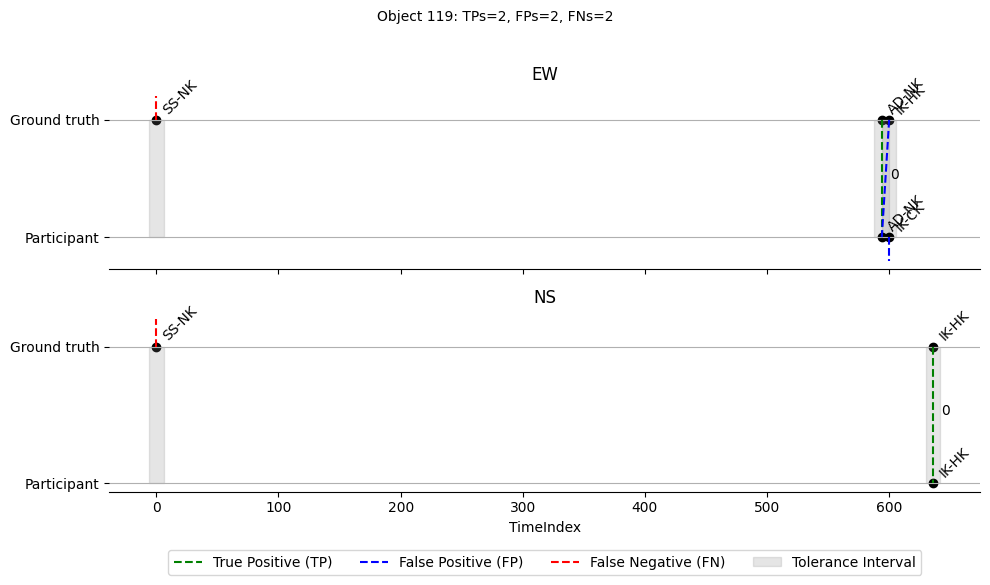

In [9]:
evaluator.plot(119)

In [28]:
t_ds, v_ds = ds_gen.get_datasets(batch_size=None, label_features=['EW_Node'], with_identifier=True, shuffle=False, stride=1)
labels = np.concatenate([element for element in t_ds.map(lambda x,y,z: [y['EW_Node']]).as_numpy_iterator()])
print(labels.shape)
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

(412124,)
{0: 38625, 1: 37452, 2: 51356, 3: 284691}


In [29]:
total = np.sum(counts)
w_0 = (1.0/counts[0])*(total*2.0)
w_1 = (1.0/counts[1])*(total*2.0)
w_2 = (1.0/counts[2])*(total*2.0)
w_3 = (1.0/counts[3])*(total*2.0)
print(f'w_0 = {w_0}')
print(f'w_1 = {w_1}')
print(f'w_2 = {w_2}')
print(f'w_3 = {w_3}')

w_0 = 21.339754045307444
w_1 = 22.008117056498985
w_2 = 16.04969234364047
w_3 = 2.8952372923625966


In [14]:
print(ds_gen.node_label_encoder.transform(['SS', 'ID', 'AD', 'IK']))
print(ds_gen.type_label_encoder.transform(['NK', 'CK', 'EK', 'HK']))

[3 1 0 2]
[3 0 1 2]


In [10]:
eval_df = classification_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True)
# LSTM 40-40@2: 0.49
# LSTM 40-40@2 zero-padding: 0.52
# LSTM 80-80@5: 0.51

14/14 [==============================] - 0s 11ms/step
Precision: 0.52
TP: 367 FP: 336


In [10]:
print(eval_df['Type'].unique())

['CK' 'NK']


In [23]:

labels=pd.read_csv(labels_dir)
labels = labels.loc[(labels['ObjectID'].isin(map(int, ds_gen.val_keys)))]
labels = labels.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(len(labels) - (len(ds_gen.val_keys)*3))
print(labels.head(5))

70
   ObjectID  TimeIndex Direction Node Type
0        10          0        EW   SS   CK
1        10          0        NS   SS   NK
2        10        216        NS   IK   CK
3        10       2171        ES   ES   ES
4        15          0        EW   SS   EK
